In [1]:
%run "preamble.ipynb"
%matplotlib inline
import torch
from torch.autograd import Variable
from dl4nlp.util import *
from torch import nn
import torch.nn.functional as F
import numpy as np
from torch.nn import Parameter
from dl4nlp.tikz import *
import IPython.display
IPython.display.display_latex(IPython.display.Latex(filename="tex/macros.tex"))

<IPython.core.display.Javascript object>

<center>
<h1>Deep Learning for Natural Language Processing II</h1>
<h2>Recurrent Neural Networks</h2>
<br>
Tim Rocktäschel<br>
<a href="https://rockt.github.com">rockt.github.com</a> <a href="mailto:tim.rocktaschel@cs.ox.ac.uk">tim.rocktaschel@cs.ox.ac.uk</a> <a href="https://twitter.com/_rockt">Twitter: @_rockt</a><br><br>
<img src="./figures/oxford.svg" width=30%><br>
2nd Int'l Summer School on Data Science, Split, Croatia<br>
27th September 2017<br>
</center>

# Sequence Tasks

<img src="./figures/proprietary/karparthy2015unreasonable/sequences.jpg" width=100%><br>
<div class=cite>[Karpathy (2015)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)</div>

# Recurrent Neural Networks

- Parameterized by cell function: 
$$f_\theta: \R^k\times\R^s \to \R^o\times\R^s$$
- Given input vector $\vec{x}_t \in \R^k$ and previous state $\vec{s}_{t-1}\in\R^s$, maps to an output vector $\vec{h}_t\in\R^o$ and next state $\vec{s}_t\in\R^s$:
$$
\vec{h}_t, \vec{s}_t = f(\vec{x}_t, \vec{s}_{t-1}). 
$$

- Given sequence of inputs
$\ls{X} = [\vec{x}_1,\ldots,\vec{x}_T]$ and a start state $\vec{s}_0$, apply cell function recursively:
$$
\rnn(f_\theta, \ls{X}, \vec{s}_0) = [f_\theta(\vec{x}_1, \vec{s}_0), \ldots, f_\theta(\vec{x}_T, \vec{s}_{T-1})]
$$

In [2]:
def rnn(cell, X, s0):
    st = s0
    H = []
    S = []
    for i in range(X.size(1)):
        ht, st = cell(X[:,i,:], st)
        H.append(ht)
        S.append(st)
    return H, S

# Fully-connected Cell

 \begin{align}
    \vec{h}_{t-1} &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{h}_t &= \tanh(\mat{W}\vec{z}_t+\vec{b})\\
    \vec{s}_t &= \vec{h}_t
  \end{align}

<img src="./figures/rnn.svg" width=50%>

<div class=cite>[Elman, 1990]</div>

# Unrolling

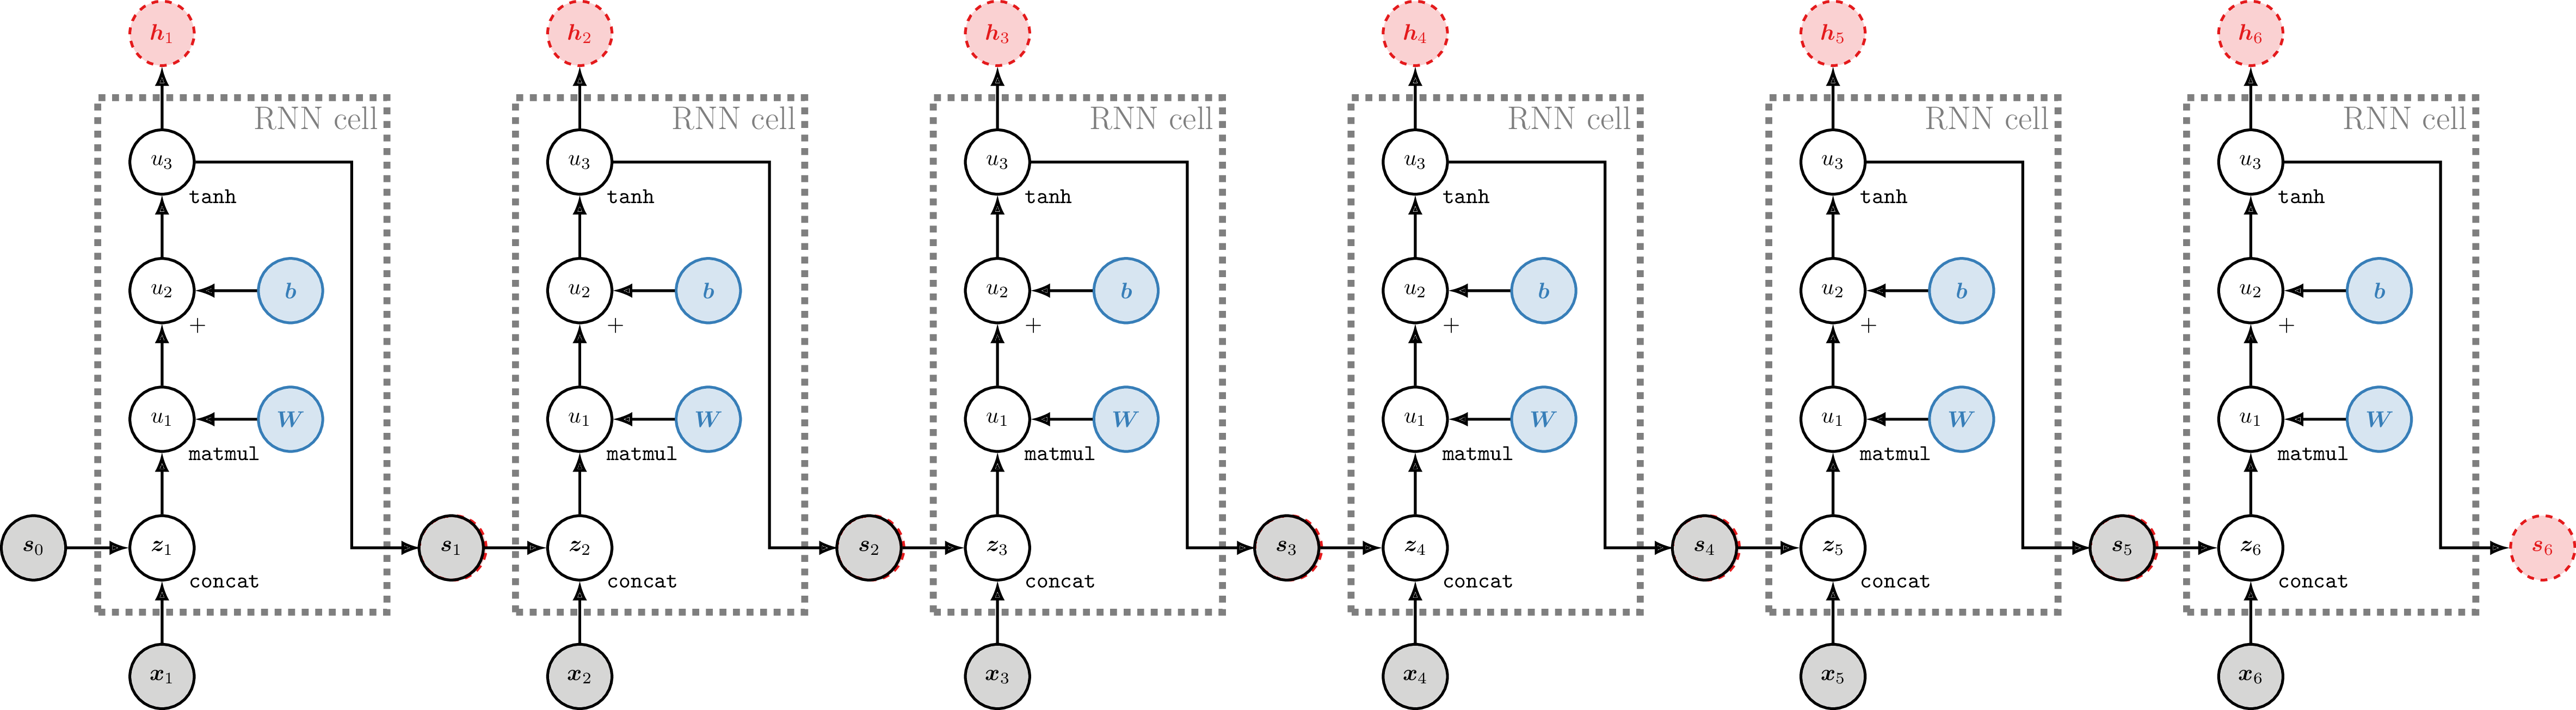

In [3]:
tikz(r"""
\foreach \x in {1,...,6} {
\pgfmathsetmacro\y{int(\x-1)}
\begin{scope}[shift={(\x * 6.5 - 6.5,1)}]
  \draw[line width = 3pt, dashed, opacity=0.5] (-1,1) rectangle (3.5,9);
  \node[opacity=0.5, anchor=north east] at (3.5,9) {\Large RNN cell};
  \node[input] (x) {$\vec{x}_\x$};
  \node[cnode, above of = x] (cons) {$\vec{z}_\x$};
  \node[input, left of = cons] (s) {$\vec{s}_\y$};
  \draw[] (x) -- (cons) node[op right] {$\cons$};
  \draw[] (s) -- (cons);

  \node[cnode, above of = cons] (mul) {$u_1$};
  \node[param, right of = mul] (W) {$\mat{W}$};
  \draw[] (cons) -- (mul) node[op right] {$\mul$};
  \draw[] (W) -- (mul);

  \node[cnode, above of = mul] (add) {$u_2$};
  \node[param, right of = add] (b) {$\vec{b}$};
  \draw[] (mul) -- (add) node[op right] {$+$};
  \draw[] (b) -- (add);

  \node[cnode, above of = add] (tanh) {$u_3$};
  \draw[] (add) -- (tanh) node[op right] {$\ntanh$};

  \node[output, above of = tanh] (h) {$\vec{h}_\x$};
  \node[output, right = 3.5cm of cons] (st) {$\vec{s}_\x$};

  \draw[] (tanh) -- (h);
  \draw[] (tanh) -| ($(cons)!0.65!(st)$) -- (st);
\end{scope}
}
""", display_width="100%", dpi=300)

In [9]:
batch_size, seq_length, k_in, k_out, vocab_size = (3, 5, 2, 2, 5) 
emb = nn.Embedding(vocab_size, k_in)
I = Variable(torch.from_numpy(np.random.randint(0, vocab_size, [batch_size, seq_length])))
X = emb(I)

W = nn.Linear(k_in+k_out, k_out)

def rnn_cell(xt, st1):
    # -- [batch_size x 2*k]
    zt = torch.cat([xt, st1], dim=1)
    # -- [batch_size x k]
    ht = F.tanh(W(zt))
    st = ht
    return ht, st 

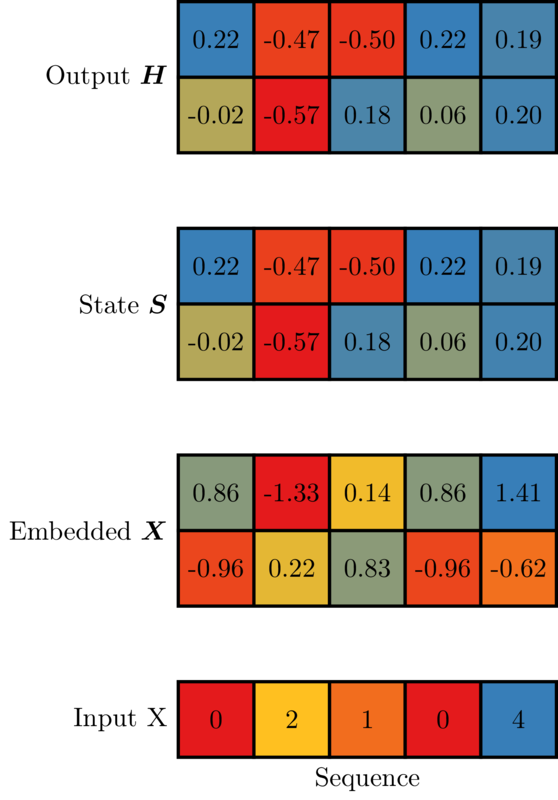

In [11]:
s0 = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
H, S = rnn(rnn_cell, X, s0)
H = torch.stack(H, dim=1)
S = torch.stack(S, dim=1)
fig = plot_matrix(I[0].unsqueeze(0)) + \
  labels(I[0].unsqueeze(0), r"Sequence", "Input $\ls{X}$")
fig += shift(plot_matrix(X[0].transpose(1, 0)) + 
             labels(X[0].transpose(1, 0), 
                    ylabel=r"Embedded $\vec{X}$"), y=2)
fig += shift(plot_matrix(S[0].transpose(1, 0)) + 
             labels(S[0].transpose(1, 0), 
                    ylabel=r"State $\mat{S}$"), y=2+k_in+1)
fig += shift(plot_matrix(H[0].transpose(1, 0)) + 
             labels(H[0].transpose(1, 0), 
                    ylabel=r"Output $\mat{H}$"), y=2+k_in+1+k_out+1)
tikz(fig, height=800)

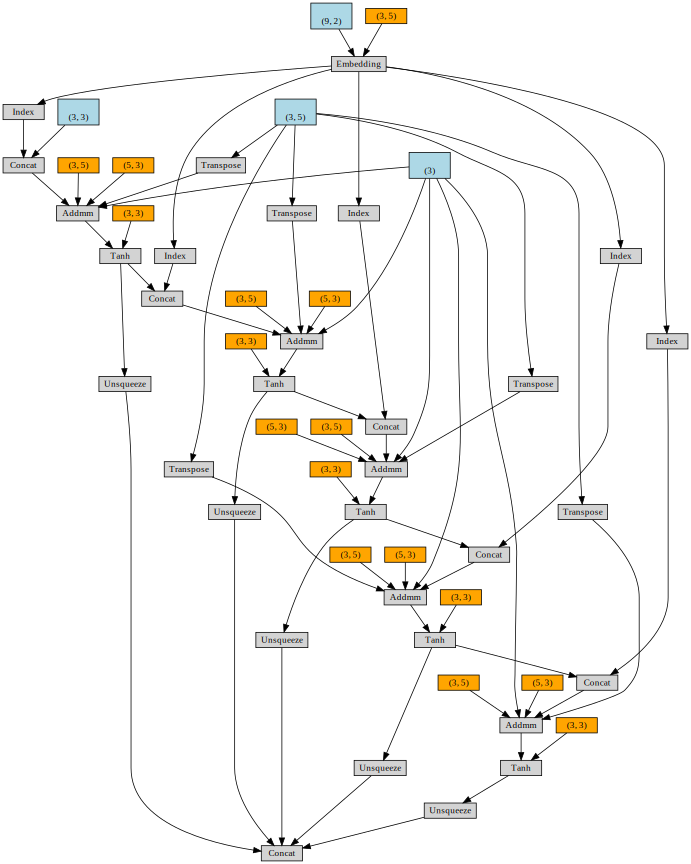

In [6]:
plot_graph(H)

# Stacking

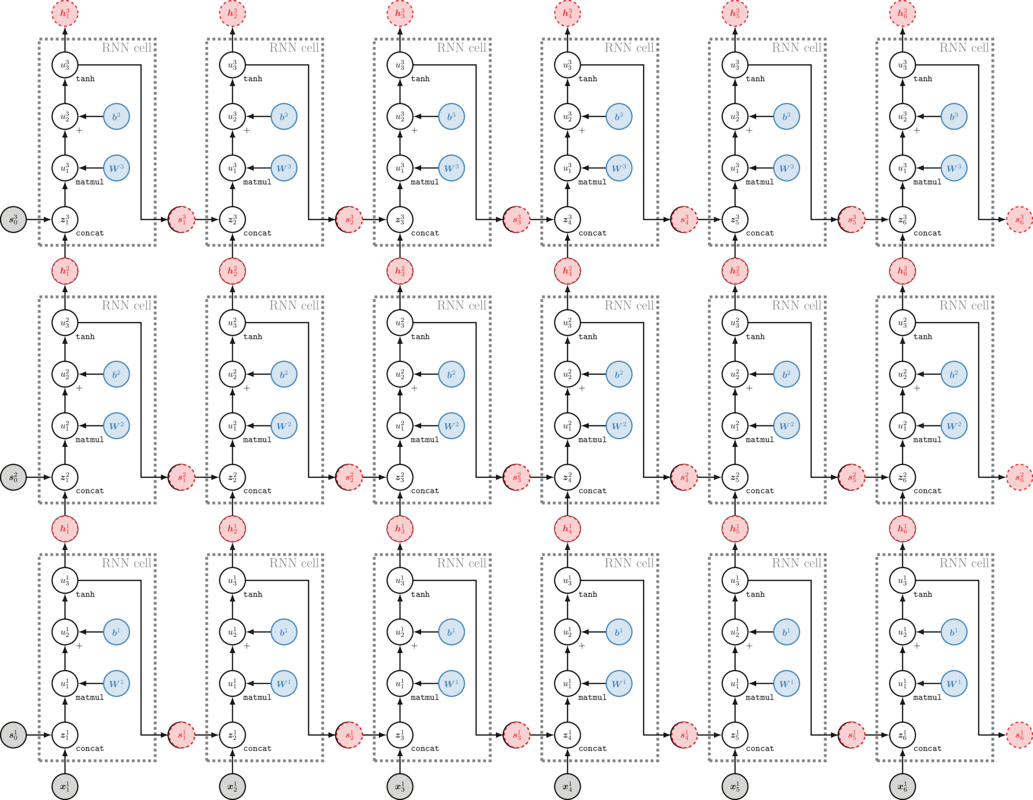

In [7]:
tikz(r"""
\foreach \l in {3,2,1} {
\foreach \x in {6,...,1} {
\pgfmathsetmacro\y{int(\x-1)}
\begin{scope}[shift={(\x * 6.5 - 6.5,\l*10)}]
  \draw[line width = 3pt, dashed, opacity=0.5] (-1,1) rectangle (3.5,9);
  \node[opacity=0.5, anchor=north east] at (3.5,9) {\Large RNN cell};
  \node[input] (x) {$\vec{x}^\l_\x$};
  \node[cnode, above of = x] (cons) {$\vec{z}^\l_\x$};
  \node[input, left of = cons] (s) {$\vec{s}^\l_\y$};
  \draw[] (x) -- (cons) node[op right] {$\cons$};
  \draw[] (s) -- (cons);

  \node[cnode, above of = cons] (mul) {$u^\l_1$};
  \node[param, right of = mul] (W) {$\mat{W}^\l$};
  \draw[] (cons) -- (mul) node[op right] {$\mul$};
  \draw[] (W) -- (mul);

  \node[cnode, above of = mul] (add) {$u^\l_2$};
  \node[param, right of = add] (b) {$\vec{b}^\l$};
  \draw[] (mul) -- (add) node[op right] {$+$};
  \draw[] (b) -- (add);

  \node[cnode, above of = add] (tanh) {$u^\l_3$};
  \draw[] (add) -- (tanh) node[op right] {$\ntanh$};

  \node[output, above of = tanh] (h) {$\vec{h}^\l_\x$};
  \node[output, right = 3.5cm of cons] (st) {$\vec{s}^\l_\x$};

  \draw[] (tanh) -- (h);
  \draw[] (tanh) -| ($(cons)!0.65!(st)$) -- (st);
\end{scope}
}
}
""", height=800, dpi=300)

# Use-case: Language Modeling

- Given a history of words $\ls{X}_{1:t-1} = [x_1, x_2, \ldots, x_{t-1}]$, predict the next word
$$
p(x_t \ | \ \ls{X}_{1:t-1})
$$
- Can be predicted from output vector $\vec{h}_t$ of an RNN at time step $t$
$$
p(x_t \ |\ \ls{X}_{1:t-1}) = \softmax(\mat{V}\vec{h}_t+\vec{b}) = \frac{\exp(\mat{V}\vec{h}_t+\vec{b})}{\sum_{j}\exp(\mat{V}\vec{h}_t+\vec{b})}
$$
where $\mat{V}\in\R^{|\set{V}|\times k}$ is an embedding matrix of all words in the vocabulary $\set{V}$ 
- Cross-entropy loss for target word $\vec{y}$ (one-hot encoding) given predicted probability distribution $\vec{\hat y} = p(x_t \ |\ \ls{X}_{1:t-1}) $
$$
L(\vec{y}, \vec{\hat y}) = - \sum_i\vec{y}_i\log(\vec{\hat y}_i)
$$



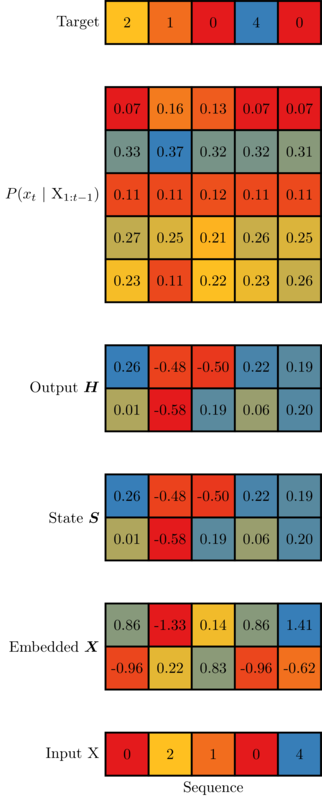

In [12]:
s0 = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
H, S = rnn(rnn_cell, X, s0)
H = torch.stack(H, dim=1)
S = torch.stack(S, dim=1)
fig = plot_matrix(I[0].unsqueeze(0)) + \
  labels(I[0].unsqueeze(0), r"Sequence", "Input $\ls{X}$")
fig += shift(plot_matrix(X[0].transpose(1, 0)) + 
             labels(X[0].transpose(1, 0), 
                    ylabel=r"Embedded $\vec{X}$"), y=2)
fig += shift(plot_matrix(S[0].transpose(1, 0)) + 
             labels(S[0].transpose(1, 0), 
                    ylabel=r"State $\mat{S}$"), y=3+k_in)
fig += shift(plot_matrix(H[0].transpose(1, 0)) + 
             labels(H[0].transpose(1, 0), 
                    ylabel=r"Output $\mat{H}$"), y=4+k_in+k_out)

project = nn.Linear(k_out, vocab_size)

log_scores = project(H).view(-1, vocab_size)
p = nn.Softmax()(log_scores).view(batch_size, -1, vocab_size)
fig += shift(plot_matrix(p[0].transpose(1, 0)) + \
             labels(p[0].transpose(1, 0), ylabel=r"$P(x_t \ |\ \ls{X}_{1:t-1})$"), y=5+k_in+2*k_out)

target = torch.cat([I[:,1:], torch.LongTensor(batch_size, 1).random_(vocab_size)], dim=1).view(-1)
fig += shift(plot_matrix(target.view(batch_size, seq_length)[0].unsqueeze(0)) + \
             labels(target.view(batch_size, seq_length)[0].unsqueeze(0), ylabel=r"Target"), y=6+k_in+2*k_out+vocab_size)

loss = nn.CrossEntropyLoss()(log_scores, target)
loss

tikz(fig, height=800)

# Neuron Specialization

<img src="figures/proprietary/specialization.png">

<div class=cite><a href="https://arxiv.org/abs/1506.02078">[Karpathy et al., 2015]</a></div>

# Back-propagation Through Time (BPTT)

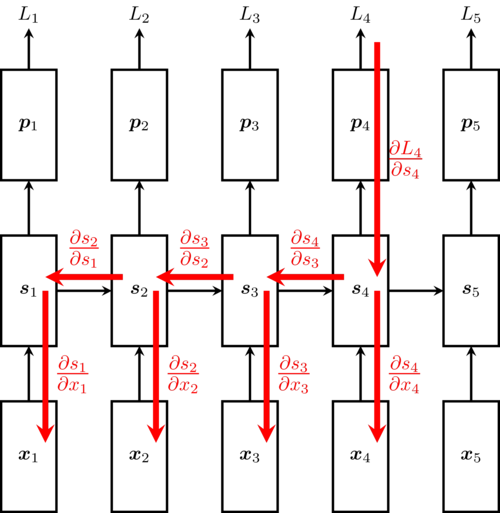

In [14]:
tikz(r"""
\foreach \x in {0,2,...,8} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \foreach \l/\label in {0/x,1/s,2/p} {
        \draw[very thick] (\x, \l*3) rectangle (\x+1, \l*3+2);
        \node[] at (\x+0.5, \l*3+1) {$\vec{\label}_{\xlabel}$};
    }
    \node[] at (\x+0.5, 9) {$L_{\xlabel}$};
    \draw[very thick, -stealth] (\x+0.5, 2) -- (\x+0.5, 3);
    \draw[very thick, -stealth] (\x+0.5, 5) -- (\x+0.5, 6);
    \draw[very thick, -stealth] (\x+0.5, 8) -- (\x+0.5, 8.75);
}
\foreach \x in {0,2,...,6} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \draw[very thick, -stealth] (\x+1, 4) -- (\x+2, 4);
    \draw[line width=3pt, -stealth, red] (\x+0.8, 4) -- 
  node[pos=0.55, anchor=west] {\Large$\frac{\partial s_\xlabel}{\partial x_\xlabel}$} (\x+0.8, 1.25);
}
\draw[line width=3pt, -stealth, red] (6.8, 8.5) -- 
  node[midway, anchor=west] {\Large$\frac{\partial L_4}{\partial s_4}$} (6.8, 4.25);
\draw[line width=3pt, -stealth, red] (6.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_4}{\partial s_3}$} (4.8, 4.25);
\draw[line width=3pt, -stealth, red] (4.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_3}{\partial s_2}$} (2.8, 4.25);
\draw[line width=3pt, -stealth, red] (2.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_2}{\partial s_1}$} (0.8, 4.25);
""", width=500) 

- RNN cell reminder
$$
 \begin{align}
    \vec{h}_{t-1} &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{h}_t &= \tanh(\mat{W}\vec{z}_t+\vec{b})\\
    \vec{s}_t &= \vec{h}_t
  \end{align}
$$

- Gradient calculation w.r.t. input embedding
$$
\begin{align}
\frac{\partial L_4}{\partial \vec{x}_1} &= 
\frac{\partial L_4}{\partial \vec{s}_4}\frac{\partial \vec{s}_4}{\partial \vec{x}_1} = \frac{\partial L_4}{\partial \vec{s}_4}\frac{\partial \vec{s}_4}{\partial \vec{s}_3}\frac{\partial \vec{s}_3}{\partial \vec{s}_2}\frac{\partial \vec{s}_2}{\partial \vec{s}_1}\frac{\partial \vec{s}_1}{\partial \vec{x}_1}
\end{align}
$$
- Gradient calculation w.r.t. transition matrix
$$
\begin{align}
\frac{\partial L_4}{\partial \mat{W}} &= \sum_{i=0}^4 \frac{\partial \vec{s}_i}{\partial \mat{W}}
\end{align}
$$
...summing up contributions from every timestep!

# Truncated Back-propagation Through Time (TBPTT)

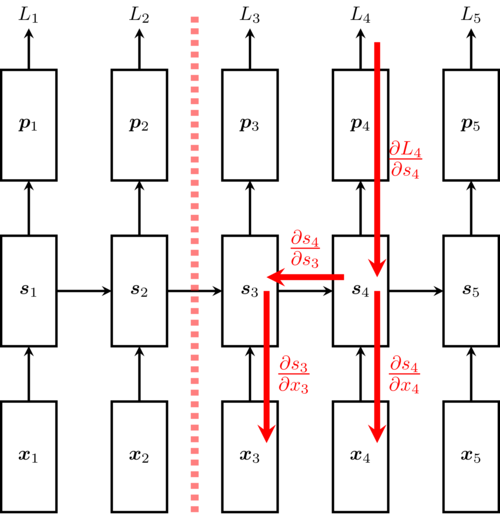

In [15]:
tikz(r"""
\foreach \x in {0,2,...,8} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \foreach \l/\label in {0/x,1/s,2/p} {
        \draw[very thick] (\x, \l*3) rectangle (\x+1, \l*3+2);
        \node[] at (\x+0.5, \l*3+1) {$\vec{\label}_{\xlabel}$};
    }
    \node[] at (\x+0.5, 9) {$L_{\xlabel}$};
    \draw[very thick, -stealth] (\x+0.5, 2) -- (\x+0.5, 3);
    \draw[very thick, -stealth] (\x+0.5, 5) -- (\x+0.5, 6);
    \draw[very thick, -stealth] (\x+0.5, 8) -- (\x+0.5, 8.75);
}
\foreach \x in {0,2,...,6} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \draw[very thick, -stealth] (\x+1, 4) -- (\x+2, 4);
}
\foreach \x in {4,6} {
    \pgfmathsetmacro\xlabel{int(\x/2.0+1)}
    \draw[line width=3pt, -stealth, red] (\x+0.8, 4) -- node[pos=0.55, anchor=west] {\Large$\frac{\partial s_\xlabel}{\partial x_\xlabel}$} (\x+0.8, 1.25);
}
\draw[line width=3pt, -stealth, red] (6.8, 8.5) -- 
  node[midway, anchor=west] {\Large$\frac{\partial L_4}{\partial s_4}$} (6.8, 4.25);
\draw[line width=3pt, -stealth, red] (6.2, 4.25) -- 
  node[midway, anchor=south] {\Large$\frac{\partial s_4}{\partial s_3}$} (4.8, 4.25);
\draw[-, line width=4pt, red, opacity=0.5, dashed] (3.5,0) -- (3.5,9);
""", width=500)

# Vanishing and Exploding Gradients
$$
\begin{align}
\vec{s}_t = \vec{h}_t &= \tanh(\underbrace{\mat{W}\vec{z}_t+\vec{b}}_{\color{nice-red}\vec{u}_t})\\
\frac{\partial \vec{s}_t}{\partial \vec{s}_{t-1}} &= \frac{\partial\vec{s}_t}{\partial\color{nice-red}\vec{u}_t}\frac{\partial\color{nice-red}\vec{u}_t}{\partial \vec{s}_{t-1}} = \text{diag}(\tanh'({\color{nice-red}\vec{u}_t}))\mat{W}\\
\frac{\partial L_n}{\partial \vec{s}_0} &= 
\frac{\partial L_n}{\partial \vec{s}_n}\frac{\partial \vec{s}_n}{\partial \vec{s}_0} = 
\frac{\partial L_n}{\partial \vec{s}_n}\frac{\partial \vec{s}_n}{\partial \vec{s}_{n-1}}\cdots\frac{\partial \vec{s}_1}{\partial \vec{s}_0} = 
\frac{\partial L_n}{\partial \vec{s}_n}\prod_{i=1}^n \frac{\partial \vec{s}_i}{\partial \vec{s}_{i-1}}\\
&= \frac{\partial L_n}{\partial \vec{s}_n}\prod_{i=1}^n \text{diag}(\tanh'({\color{nice-red}\vec{u}_i}))\mat{W}\\
\end{align}
$$

- Stable gradient propagation if $\max(\text{eig}(\mat{W})) = 1$
- Vanishing gradient if $\max(\text{eig}(\mat{W})) < 1$
- Exploding gradient if $\max(\text{eig}(\mat{W})) > 1$

# Long Short-term Memory (LSTM)

  \begin{align}
    \left[{
      \begin{array}{*{20}c}
        \vec{h}_{t-1} \\
        \vec{c}_{t-1}
      \end{array} }
    \right] &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{i}_t &= \sigma(\mat{W}^i\vec{z}_t+\vec{b}^i) \label{input}\\
    \vec{f}_t &= \sigma(\mat{W}^f\vec{z}_t+\vec{b}^f) \label{forget}\\
    \vec{o}_t &= \sigma(\mat{W}^o\vec{z}_t+\vec{b}^o) \label{output}\\
    \vec{c}_t &= \vec{f}_t \odot \vec{c}_{t-1} + \vec{i}_t \odot
    \tanh(\mat{W}^c\vec{z}_t+\vec{b}^c)\\
    \vec{h}_t &= \vec{o}_t \odot \tanh(\vec{c}_t)\\
    \vec{s}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{h}_t \\
        \vec{c}_t
      \end{array} }
    \right]
  \end{align}

<img src="./figures/lstm.svg" width=80%>

<div class=cite>[Hochreiter and Schmidhuber, 1997]</div>

In [16]:
Wi = nn.Linear(k_in+k_out, k_out)
Wf = nn.Linear(k_in+k_out, k_out)
Wo = nn.Linear(k_in+k_out, k_out)
Wc = nn.Linear(k_in+k_out, k_out)

def lstm_cell(xt, st1):
    ht1, ct1 = st1
    zt = torch.cat([xt, ht1], dim=1)
    it = F.sigmoid(Wi(zt))
    ft = F.sigmoid(Wf(zt))
    ot = F.sigmoid(Wo(zt))
    ct = ft * ct1 + it * F.tanh(Wc(zt))
    ht = ot * F.tanh(ct)
    st = (ht, ct)
    return ht, st 

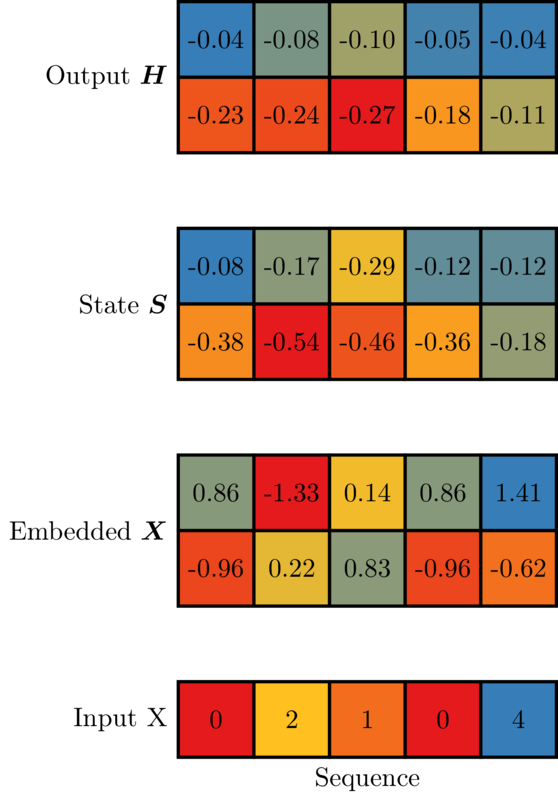

In [19]:
s0h = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
s0c = nn.init.normal(Parameter(torch.randn(batch_size, k_out)))
H, S = rnn(lstm_cell, X, (s0h, s0c))
H = torch.stack(H, dim=1)
S = torch.stack([s[1] for s in S], dim=1)
fig = plot_matrix(I[0].unsqueeze(0)) + \
  labels(I[0].unsqueeze(0), r"Sequence", "Input $\ls{X}$")
fig += shift(plot_matrix(X[0].transpose(1, 0)) + 
             labels(X[0].transpose(1, 0), 
                    ylabel=r"Embedded $\vec{X}$"), y=2)
fig += shift(plot_matrix(S[0].transpose(1, 0)) + 
             labels(S[0].transpose(1, 0), 
                    ylabel=r"State $\mat{S}$"), y=2+k_in+1)
fig += shift(plot_matrix(H[0].transpose(1, 0)) + 
             labels(H[0].transpose(1, 0), 
                    ylabel=r"Output $\mat{H}$"), y=2+k_in+1+k_out+1)
tikz(fig, height=800)

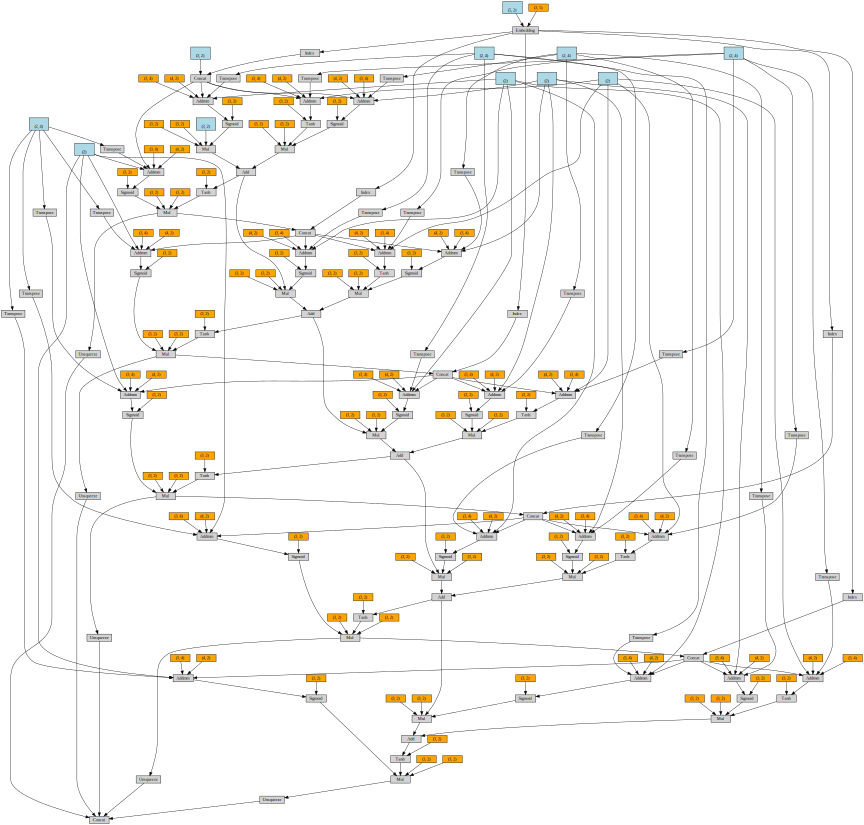

In [20]:
plot_graph(H)

# LSTMs mitigate Vanishing/Exploding Gradients

<img src="figures/proprietary/rnns_slow.gif">

# Speed Optimization

In [23]:
Wi = nn.Linear(k_in+k_out, k_out)
Wf = nn.Linear(k_in+k_out, k_out)
Wo = nn.Linear(k_in+k_out, k_out)
Wc = nn.Linear(k_in+k_out, k_out)

def lstm_cell(xt, st1):
    ht1, ct1 = st1
    zt = torch.cat([xt, ht1], dim=1)
    it = F.sigmoid(Wi(zt))
    ft = F.sigmoid(Wf(zt))
    ot = F.sigmoid(Wo(zt))
    ct = ft * ct1 + it * F.tanh(Wc(zt))
    ht = ot * F.tanh(ct)
    st = (ht, ct)
    return ht, st 

In [24]:
W = nn.Linear(k_in+k_out, 4*k_out)

def lstm_cell(xt, st1):
    ht1, ct1 = st1
    zt = torch.cat([xt, ht1], dim=1)
    wi, wf, wo, wc = W(zt).split(k_out, dim=1)
    it = F.sigmoid(wi)
    ft = F.sigmoid(wf)
    ot = F.sigmoid(wo)
    ct = ft * ct1 + it * F.tanh(wc)
    ht = ot * F.tanh(ct)
    st = (ht, ct)
    return ht, st 

# Gated Recurrent Unit (GRU)

 \begin{align}
    \vec{h}_{t-1} &= \vec{s}_{t-1}\\
    \vec{z}_t &= \left[{
      \begin{array}{*{20}c}
        \vec{x}_t \\
        \vec{h}_{t-1}
      \end{array} }
    \right]\\
    \vec{u}_t &= \sigma(\mat{W}^u\vec{z}_t+\vec{b}^u)\\
    \vec{r}_t &= \sigma(\mat{W}^r\vec{z}_t+\vec{b}^r)\\
    \vec{n}_t &= \tanh(\mat{W}^x\vec{x}_t + \vec{b}^x) + \vec{r}_t \odot (\mat{W}^h\vec{h}_{t-1} + \vec{b}^h)\\
    \vec{h}_t &= \vec{u}_t \odot \vec{h}_{t-1} + (1 - \vec{u}_t) \odot \vec{n}_t\\
    \vec{s}_t &= \vec{h}_t
  \end{align}

In [25]:
Wu = nn.Linear(k_in+k_out, k_out)
Wr = nn.Linear(k_in+k_out, k_out)
Wx = nn.Linear(k_in, k_out)
Wh = nn.Linear(k_out, k_out)
def gru_cell(xt, st1):
    ht1 = st1
    zt = torch.cat([xt, ht1], dim=1)
    ut = F.sigmoid(Wu(zt))
    rt = F.sigmoid(Wr(zt))
    nt = F.tanh(Wx(xt)) + rt * (Wh(ht1))
    ht = ut * ht1 + (1-ut) * nt
    st = ht
    return ht, st 

<div class=cite>[Cho et al., 2014]</div>

# Quasi-recurrent Neural Networks (QRNNs)

<img src="./figures/proprietary/bradbury2016quasi/model.svg" width=100%>

<div class=cite><a href="https://arxiv.org/abs/1611.01576">[Bradbury et al., 2016]</a></div>

# Bidirectional RNNs
- Run one RNN forward and another one backward 
- Concatenate forward and backward output vectors


# Use-case: Stance Detection

<img src="./figures/bidirectional.svg" width=100%>

<div class=cite>[Augenstein et al., 2016]</div>

# Use-case: Sequence Tagging
- Given a input sequence $\ls{X} = [x_1, x_2, \ldots, x_N]$, predict label sequence $\ls{Y} = [y_1, y_2, \ldots, y_N]$
$$
p(\ls{Y}\ |\ \ls{X})
$$
- $y_t$ be predicted from output vector $\vec{h}_t$ of an RNN at time step $t$
$$
p(y_t \ |\ \ls{X}) = \softmax(\mat{V}\vec{h}_t+\vec{b})
$$
- Cross-entropy loss
$$
- \sum_i\vec{y}_i\log(\vec{\hat y}_i)
$$

<img src="./figures/proprietary/lample2016neural/word.svg" width=80%> | <img src="./figures/proprietary/lample2016neural/char.svg" width=80%>
:--:|:--:

<div class=cite><a href="https://arxiv.org/abs/1603.01360">[Lample et al., 2016]</a></div>

# Recurrent Dropout

<img src="./figures/proprietary/gal2016theoretically/dropout.png" width=80%>

<div class=cite><a href="http://papers.nips.cc/paper/6241-a-theoretically-grounded-application-of-dropout-in-recurrent-neural-networks.pdf">[Gal and Ghahramani, 2016]</a></div>

# Sentence Representations

<img src="./figures/proprietary/kiros2014skip/model.svg" width=80%>

<div class=cite><a href="http://papers.nips.cc/paper/5950-skip-thought-vectors.pdf">[Kiros et al., 2014]</a></div>

# Further Reading
- [Cho. Natural Language Understanding. 2016](https://drive.google.com/file/d/0B_wzP_JlVFcKc0xrMjRhRU9DN2JRQlB0TjdkdmpLZ0FSaTFZ/view)
- [Goldberg. The Unreasonable Effectiveness of Character-level Language Models. 2015.](http://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139)
- [Karpathy. The Unreasonable Effectiveness of Recurrent Neural Networks. 2015.](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
- [Merity. Explaining and illustrating orthogonal initialization for recurrent neural networks. 2016](http://smerity.com/articles/2016/orthogonal_init.html)